In [4]:
!pip install torchsummary

  Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
!pip install pytorch_ssim

  Created wheel for pytorch-ssim: filename=pytorch_ssim-0.1-py3-none-any.whl size=2027 sha256=774cd27cf66fd3121faa7f48286cb878889ab38786178437980ba718bd485fdf
  Stored in directory: /root/.cache/pip/wheels/ee/20/09/ebf5e58bdf2560c760074cd140b7f7b0c882e216feabf1ae30
Successfully built pytorch-ssim
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
%matplotlib inline
import os, glob, random
import pytorch_ssim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from ignite.metrics import SSIM
import torch
from random import sample
from torchsummary import summary
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

In [ ]:
!wandb login 3e8c2e01bacb844caa27f15d0c4ae7f63d683a5e

In [5]:
pl.__version__

'1.0.2'

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

---
## Dataset

In [7]:
class ImageTransform:
    def __init__(self, img_size=256):
        self.transform = {
            'train': transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ]),
            'test': transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])}

    def __call__(self, img, phase='train'):
        img = self.transform[phase](img)

        return img


# Custom Dataset ---------------------------------------------------------------------------
class CustomDataset(Dataset):
    def __init__(self, sketch_img_paths, photo_img_paths,  transform, phase='train'):
        self.sketch_img_paths = sketch_img_paths
        self.photo_img_paths = photo_img_paths
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return min([len(self.sketch_img_paths), len(self.photo_img_paths)])

    def __getitem__(self, idx):        
        sketch_img_paths = self.sketch_img_paths[idx]
        photo_idx = np.random.randint(0, len(self.photo_img_paths))
        photo_img_paths = self.photo_img_paths[photo_idx]
        sketch_img = Image.open(sketch_img_paths)
        photo_img = Image.open(photo_img_paths)

        sketch_img = self.transform(sketch_img, self.phase)
        photo_img = self.transform(photo_img, self.phase)

        return sketch_img, photo_img

In [8]:
# Data Module
class DataModule(pl.LightningDataModule):
    def __init__(self, data_dir, transform, batch_size, phase='train', seed=0):
        super(DataModule, self).__init__()
        self.data_dir = data_dir
        self.transform = transform
        self.batch_size = batch_size
        self.phase = phase
        self.seed = seed
        self.sketch_img_paths = glob.glob(os.path.join(self.data_dir, 'sketches/sketches', '*.jpg'))
        self.photo_img_paths = glob.glob(os.path.join(self.data_dir, 'photos/photos', '*.jpg'))
        X_train, X_test, y_train, y_test = train_test_split(self.sketch_img_paths, self.photo_img_paths, test_size=0.2, random_state=42, shuffle=True)        
        self.train_dataset = CustomDataset(X_train, y_train, self.transform, self.phase)
        self.val_dataset = CustomDataset(X_test, y_test, self.transform, self.phase)
        self.test_dataset = CustomDataset(X_test, y_test, self.transform, self.phase)

    def train_dataloader(self):
        '''
        DataLoader của hàm train
        '''
        return DataLoader(self.train_dataset,
                  batch_size=self.batch_size,
                  shuffle=True,
                  pin_memory=True,
                  drop_last=True
                 )
    

    def val_dataloader(self):
        '''
        DataLoader của hàm validate
        '''
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
        )

    def test_dataloader(self):
        '''
        DataLoader của hàm test
        '''
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
        )

In [9]:
# Sanity Check
data_dir = '/kaggle/input/cuhk-dataset-256'
transform = ImageTransform(img_size=256)
batch_size = 8

dm = DataModule(data_dir, transform, batch_size, phase='test')
dm.prepare_data()

dataloader = dm.train_dataloader()
base, style = next(iter(dataloader))

print('Input Shape {}, {}'.format(base.size(), style.size()))

Input Shape torch.Size([8, 3, 256, 256]), torch.Size([8, 3, 256, 256])


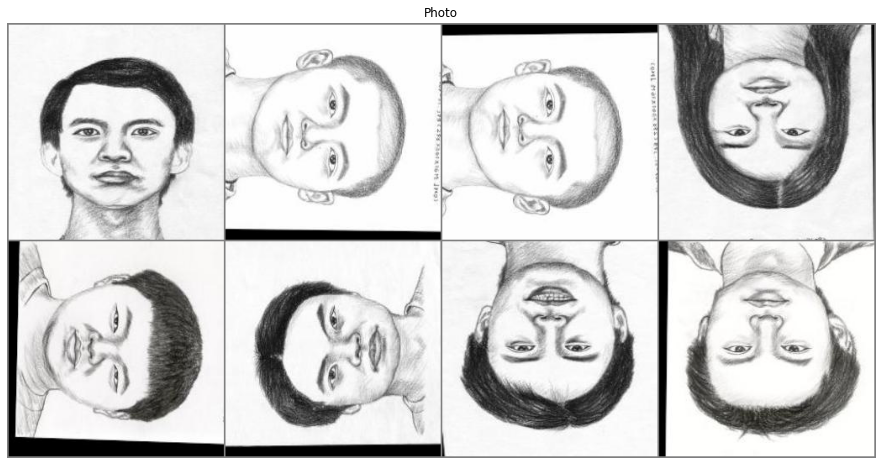

In [10]:
temp = make_grid(base, nrow=4, padding=2).permute(1, 2, 0).detach().numpy()
temp = temp * 0.5 + 0.5
temp = temp * 255.0
temp = temp.astype(int)

fig = plt.figure(figsize=(18, 8), facecolor='w')
plt.imshow(temp)
plt.axis('off')
plt.title('Photo')
plt.show()

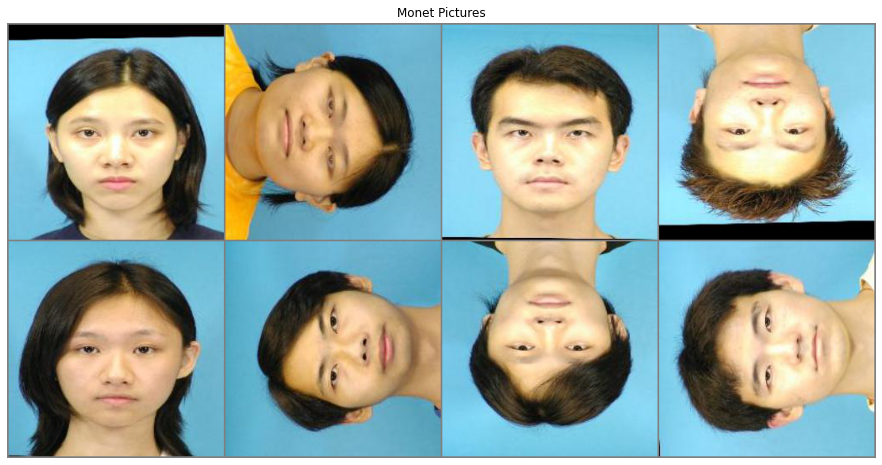

In [11]:
temp = make_grid(style, nrow=4, padding=2).permute(1, 2, 0).detach().numpy()
temp = temp * 0.5 + 0.5
temp = temp * 255.0
temp = temp.astype(int)

fig = plt.figure(figsize=(18, 8), facecolor='w')
plt.imshow(temp)
plt.axis('off')
plt.title('Monet Pictures')
plt.show()

---
## Model

In [12]:
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, dropout=True):
        super(Upsample, self).__init__()
        self.dropout = dropout
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=nn.InstanceNorm2d),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.dropout_layer = nn.Dropout2d(0.5)

    def forward(self, x, shortcut=None):
        x = self.block(x)
        if self.dropout:
            x = self.dropout_layer(x)

        if shortcut is not None:
            x = torch.cat([x, shortcut], dim=1)

        return x


class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, apply_instancenorm=True):
        super(Downsample, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=nn.InstanceNorm2d)
        self.norm = nn.InstanceNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.apply_norm = apply_instancenorm

    def forward(self, x):
        x = self.conv(x)
        if self.apply_norm:
            x = self.norm(x)
        x = self.relu(x)

        return x


class CycleGAN_Unet_Generator(nn.Module):
    def __init__(self, filter=64):
        super(CycleGAN_Unet_Generator, self).__init__()
        self.downsamples = nn.ModuleList([
            Downsample(3, filter, kernel_size=4, apply_instancenorm=False),  # (b, filter, 128, 128)
            Downsample(filter, filter * 2),  # (b, filter * 2, 64, 64)
            Downsample(filter * 2, filter * 4),  # (b, filter * 4, 32, 32)
            Downsample(filter * 4, filter * 8),  # (b, filter * 8, 16, 16)
            Downsample(filter * 8, filter * 8), # (b, filter * 8, 8, 8)
            Downsample(filter * 8, filter * 8), # (b, filter * 8, 4, 4)
            Downsample(filter * 8, filter * 8), # (b, filter * 8, 2, 2)
        ])

        self.upsamples = nn.ModuleList([
            Upsample(filter * 8, filter * 8),
            Upsample(filter * 16, filter * 8),
            Upsample(filter * 16, filter * 8),
            Upsample(filter * 16, filter * 4, dropout=False),
            Upsample(filter * 8, filter * 2, dropout=False),
            Upsample(filter * 4, filter, dropout=False)
        ])

        self.last = nn.Sequential(
            nn.ConvTranspose2d(filter * 2, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        skips = []
        for l in self.downsamples:
            x = l(x)
            skips.append(x)

        skips = reversed(skips[:-1])
        for l, s in zip(self.upsamples, skips):
            x = l(x, s)

        out = self.last(x)

        return out


class CycleGAN_Discriminator(nn.Module):
    def __init__(self, filter=64):
        super(CycleGAN_Discriminator, self).__init__()

        self.block = nn.Sequential(
            Downsample(3, filter, kernel_size=4, stride=2, apply_instancenorm=False),
            Downsample(filter, filter * 2, kernel_size=4, stride=2),
            Downsample(filter * 2, filter * 4, kernel_size=4, stride=2),
            Downsample(filter * 4, filter * 8, kernel_size=4, stride=1),
        )

        self.last = nn.Conv2d(filter * 8, 1, kernel_size=4, stride=1, padding=1)

    def forward(self, x):
        x = self.block(x)
        x = self.last(x)

        return x

In [13]:
# Sanity Check
# net = CycleGAN_Unet_Generator()

# out = net(base)
# print(out.size())
summary(CycleGAN_Unet_Generator().float().cuda(), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
        Downsample-3         [-1, 64, 128, 128]               0
            Conv2d-4          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-5          [-1, 128, 64, 64]               0
         LeakyReLU-6          [-1, 128, 64, 64]               0
        Downsample-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-9          [-1, 256, 32, 32]               0
        LeakyReLU-10          [-1, 256, 32, 32]               0
       Downsample-11          [-1, 256, 32, 32]               0
           Conv2d-12          [-1, 512, 16, 16]       2,097,664
   InstanceNorm2d-13          [-1, 512, 16, 16]               0
        LeakyReLU-14          [-1, 512,

In [14]:
# Sanity Check
# net = CycleGAN_Discriminator()

# out = net(base)
# print(out.size())
summary(CycleGAN_Discriminator().float().cuda(), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
        Downsample-3         [-1, 64, 128, 128]               0
            Conv2d-4          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-5          [-1, 128, 64, 64]               0
         LeakyReLU-6          [-1, 128, 64, 64]               0
        Downsample-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-9          [-1, 256, 32, 32]               0
        LeakyReLU-10          [-1, 256, 32, 32]               0
       Downsample-11          [-1, 256, 32, 32]               0
           Conv2d-12          [-1, 512, 31, 31]       2,097,664
   InstanceNorm2d-13          [-1, 512, 31, 31]               0
        LeakyReLU-14          [-1, 512,

In [15]:
# CycleGAN - Lightning Module ---------------------------------------------------------------------------
from ignite.engine.engine import Engine
import tensorflow as tf
class CycleGAN_LightningSystem(pl.LightningModule):
    def __init__(self, G_basestyle, G_stylebase, D_base, D_style, lr, transform, reconstr_w=10, id_w=2):
        super(CycleGAN_LightningSystem, self).__init__()
        self.G_basestyle = G_basestyle
        self.G_stylebase = G_stylebase
        self.D_base = D_base
        self.D_style = D_style
        self.lr = lr
        self.transform = transform
        self.reconstr_w = reconstr_w
        self.id_w = id_w
        self.cnt_train_step = 0
        self.step = 0

        self.mae = nn.L1Loss()
        self.generator_loss = nn.MSELoss()
        self.discriminator_loss = nn.MSELoss()
        self.losses = []
        self.G_mean_losses = []
        self.D_mean_losses = []
        self.validity = []
        self.reconstr = []
        self.identity = []
        self.metric_SSIM = []
        
        self.default_evaluator = Engine(self.eval_step)
        self.metric = SSIM(data_range=1.0)
        self.metric.attach(self.default_evaluator, 'ssim')
        self.dm = DataModule(data_dir, transform, batch_size, seed=42) 

    def configure_optimizers(self):
        self.g_basestyle_optimizer = optim.Adam(self.G_basestyle.parameters(), lr=self.lr['G'], betas=(0.5, 0.999))
        self.g_stylebase_optimizer = optim.Adam(self.G_stylebase.parameters(), lr=self.lr['G'], betas=(0.5, 0.999))
        self.d_base_optimizer = optim.Adam(self.D_base.parameters(), lr=self.lr['D'], betas=(0.5, 0.999))
        self.d_style_optimizer = optim.Adam(self.D_style.parameters(), lr=self.lr['D'], betas=(0.5, 0.999))

        return [self.g_basestyle_optimizer, self.g_stylebase_optimizer, self.d_base_optimizer, self.d_style_optimizer], []
    
    def eval_step(self, engine, batch):
        return batch

    def training_step(self, batch, batch_idx, optimizer_idx):
        sketch_img, photo_img = batch
        b = sketch_img.size()[0]

        valid = torch.ones(b, 1, 30, 30).cuda()
        fake = torch.zeros(b, 1, 30, 30).cuda()

        # Train Generator
        if optimizer_idx == 0 or optimizer_idx == 1:
            # Validity
            # MSELoss
            val_base = self.generator_loss(self.D_base(self.G_stylebase(photo_img)), valid)
            val_style = self.generator_loss(self.D_style(self.G_basestyle(sketch_img)), valid)
            val_loss = (val_base + val_style) / 2

            # Reconstruction
            reconstr_base = self.mae(self.G_stylebase(self.G_basestyle(sketch_img)), sketch_img)
            reconstr_style = self.mae(self.G_basestyle(self.G_stylebase(photo_img)), photo_img)
            reconstr_loss = (reconstr_base + reconstr_style) / 2
            
            # Identity
            id_base = self.mae(self.G_stylebase(sketch_img), sketch_img)
            id_style = self.mae(self.G_basestyle(photo_img), photo_img)
            id_loss = (id_base + id_style) / 2

            # Loss Weight
            G_loss = val_loss + self.reconstr_w * reconstr_loss + self.id_w * id_loss
            
            # SSIM metric
            y_pre = self.G_basestyle(sketch_img)
            state = self.default_evaluator.run([[y_pre, photo_img]]).metrics['ssim']
            self.log('G_loss', G_loss)
            self.log('SSIM_train', state)
            
            return {'loss': G_loss, 'validity': val_loss, 'reconstr': reconstr_loss, 'identity': id_loss}

        # Train Discriminator
        elif optimizer_idx == 2 or optimizer_idx == 3:
            # MSELoss
            D_base_gen_loss = self.discriminator_loss(self.D_base(self.G_stylebase(photo_img)), fake)
            D_style_gen_loss = self.discriminator_loss(self.D_style(self.G_basestyle(sketch_img)), fake)
            D_base_valid_loss = self.discriminator_loss(self.D_base(sketch_img), valid)
            D_style_valid_loss = self.discriminator_loss(self.D_style(photo_img), valid)
            
            D_gen_loss = (D_base_gen_loss + D_style_gen_loss) / 2
            
            # Loss Weight
            D_loss = (D_gen_loss + D_base_valid_loss + D_style_valid_loss) / 3

            # Count up
            self.cnt_train_step += 1
            self.log('D_loss', D_loss)
            return {'loss': D_loss}
        
    def validation_step(self, batch, batch_idx):
            '''
            Hàm này nhận vào một batch
            lấy kết quả của mô hình và tính loss

            '''
            sketch_img, photo_img = batch
            outputs = self.G_basestyle(sketch_img)
            ssim = self.default_evaluator.run([[outputs, photo_img]]).metrics['ssim']
            self.log("SSIM_train", ssim)
            self.log("SSIM_valid", ssim)
            return ssim

    def test_step(self, batch, batch_idx):
            sketch_img, photo_img = batch
            outputs = self.G_basestyle(sketch_img)
            ssim = self.default_evaluator.run([[outputs, photo_img]]).metrics['ssim']
            self.log("SSIM_train", ssim)
            self.log("SSIM_test", ssim)
            return ssim

    def training_epoch_end(self, outputs):
        self.step += 1
        
        avg_loss = sum([torch.stack([x['loss'] for x in outputs[i]]).mean().item() / 4 for i in range(4)])
        G_mean_loss = sum([torch.stack([x['loss'] for x in outputs[i]]).mean().item() / 2 for i in [0, 1]])
        D_mean_loss = sum([torch.stack([x['loss'] for x in outputs[i]]).mean().item() / 2 for i in [2, 3]])
        validity = sum([torch.stack([x['validity'] for x in outputs[i]]).mean().item() / 2 for i in [0, 1]])
        reconstr = sum([torch.stack([x['reconstr'] for x in outputs[i]]).mean().item() / 2 for i in [0, 1]])
        identity = sum([torch.stack([x['identity'] for x in outputs[i]]).mean().item() / 2 for i in [0, 1]])
#         ssim = sum([torch.stack([x['metric_SSIM'] for x in outputs[i]]).mean().item() / 2 for i in [0, 1]])
            
        self.losses.append(avg_loss)
        self.G_mean_losses.append(G_mean_loss)
        self.D_mean_losses.append(D_mean_loss)
        self.validity.append(validity)
        self.reconstr.append(reconstr)
        self.identity.append(identity)
#         self.metric_SSIM.append(ssim)
        
        if self.step % 1 == 0:
            # Display Model Output
            target_img_paths = glob.glob('/kaggle/input/cuhk-dataset-256/sketches/sketches/*.jpg')
            sample_data = sample(target_img_paths, 4)
            target_imgs = [self.transform(Image.open(path), phase='test') for path in sample_data]
            photos_imgs = [self.transform(Image.open(path.replace('sketches', 'photos')), phase='test') for path in sample_data]
            target_imgs = torch.stack(target_imgs, dim=0)
            target_imgs = target_imgs.cuda()
            
            photos_imgs = torch.stack(photos_imgs, dim=0)
            photos_imgs = photos_imgs.cuda()
            
            gen_imgs = self.G_basestyle(target_imgs)
            gen_img = torch.cat([target_imgs, gen_imgs, photos_imgs], dim=0)

            # Reverse Normalization
            gen_img = gen_img * 0.5 + 0.5
            gen_img = gen_img * 255

            joined_images_tensor = make_grid(gen_img, nrow=4, padding=2)

            joined_images = joined_images_tensor.detach().cpu().numpy().astype(int)
            joined_images = np.transpose(joined_images, [1,2,0])

            # Visualize
            fig = plt.figure(figsize=(18, 8))
            plt.imshow(joined_images)
            plt.axis('off')
            plt.title(f'Epoch {self.step}')
            plt.show()
            plt.clf()
            plt.close()

        return None

In [16]:
def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.
    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                nn.init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fa n_in')
            elif init_type == 'orthogonal':
                nn.init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            nn.init.normal_(m.weight.data, 1.0, init_gain)
            nn.init.constant_(m.bias.data, 0.0)

    net.apply(init_func)  # apply the initialization function <init_func>

---
## Train

In [17]:
wandb_logger = pl.loggers.WandbLogger(
    project="GAN-project", name='model-gan-ver-3', log_model="all"
)
lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="step")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: Currently logged in as: hoabeocute2001 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name               | Type                    | Params
---------------------------------------------------------------
0 | G_basestyle        | CycleGAN_Unet_Generator | 41 M  
1 | G_stylebase        | CycleGAN_Unet_Generator | 41 M  
2 | D_base             | CycleGAN_Discriminator  | 2 M   
3 | D_style            | CycleGAN_Discriminator  | 2 M   
4 | mae                | L1Loss                  | 0     
5 | generator_loss     | MSELoss                 | 0     
6 | discriminator_loss | MSELoss                 | 0     


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You are using LearningRateMonitor callback with models that have no learning rate schedulers. Please see documentation for `configure_optimizers` method.
  warnings.warn(*args, **kwargs)


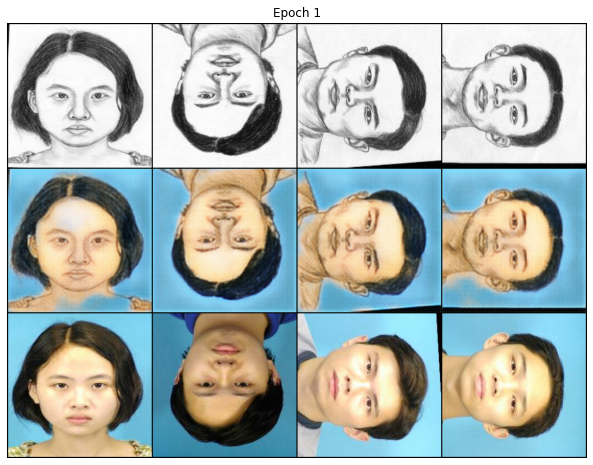

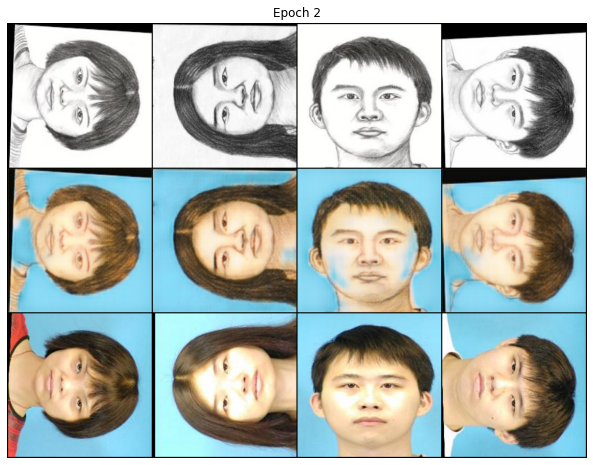

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [18]:
# Config  -----------------------------------------------------------------
data_dir = '/kaggle/input/cuhk-dataset-256'
transform = ImageTransform(img_size=256)
batch_size = 1
lr = {
    'G': 0.0002,
    'D': 0.0002
}
epoch = 50
seed = 42
reconstr_w = 10
id_w = 2
seed_everything(seed)

# DataModule  -----------------------------------------------------------------
dm = DataModule(data_dir, transform, batch_size, seed=seed)

G_basestyle = CycleGAN_Unet_Generator()
G_stylebase = CycleGAN_Unet_Generator()
D_base = CycleGAN_Discriminator()
D_style = CycleGAN_Discriminator()

# Init Weight  --------------------------------------------------------------
for net in [G_basestyle, G_stylebase, D_base, D_style]:
    init_weights(net, init_type='normal')

# LightningModule  --------------------------------------------------------------
model = CycleGAN_LightningSystem(G_basestyle, G_stylebase, D_base, D_style, 
                                 lr, transform, reconstr_w, id_w)

lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="step")
# Trainer  --------------------------------------------------------------
trainer = Trainer(
    logger=wandb_logger,
    callbacks=[lr_monitor],
    max_epochs=epoch,
    gpus=1,
    checkpoint_callback=False,
    log_every_n_steps=1,
    reload_dataloaders_every_epoch=True
)


# Train
trainer.fit(model, datamodule=dm)

In [19]:
# def submit(model, transform):
#     os.makedirs('../images', exist_ok=True)
#     net = model.G_basestyle
    
#     net.eval()
#     photo_img_paths = glob.glob('/kaggle/input/cuhk-dataset-256/sketches/sketches/*.jpg')
    
#     for path in photo_img_paths:
#         photo_id = path.split('/')[-1]
#         img = transform(Image.open(path), phase='test')
        
#         gen_img = net(img.unsqueeze(0))[0]
        
#         # Reverse Normalization
#         gen_img = gen_img * 0.5 + 0.5
#         gen_img = gen_img * 255
#         gen_img = gen_img.detach().cpu().numpy().astype(np.uint8)
#         5      
#         gen_img = np.transpose(gen_img, [1,2,0])
        
#         gen_img = Image.fromarray(gen_img)
#         gen_img.save(os.path.join('../images', photo_id))
        
#     # Make Zipfile
#     shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")
    
#     # Delete Origin file
#     shutil.rmtree('../images')

In [20]:
# submit(model, transform)

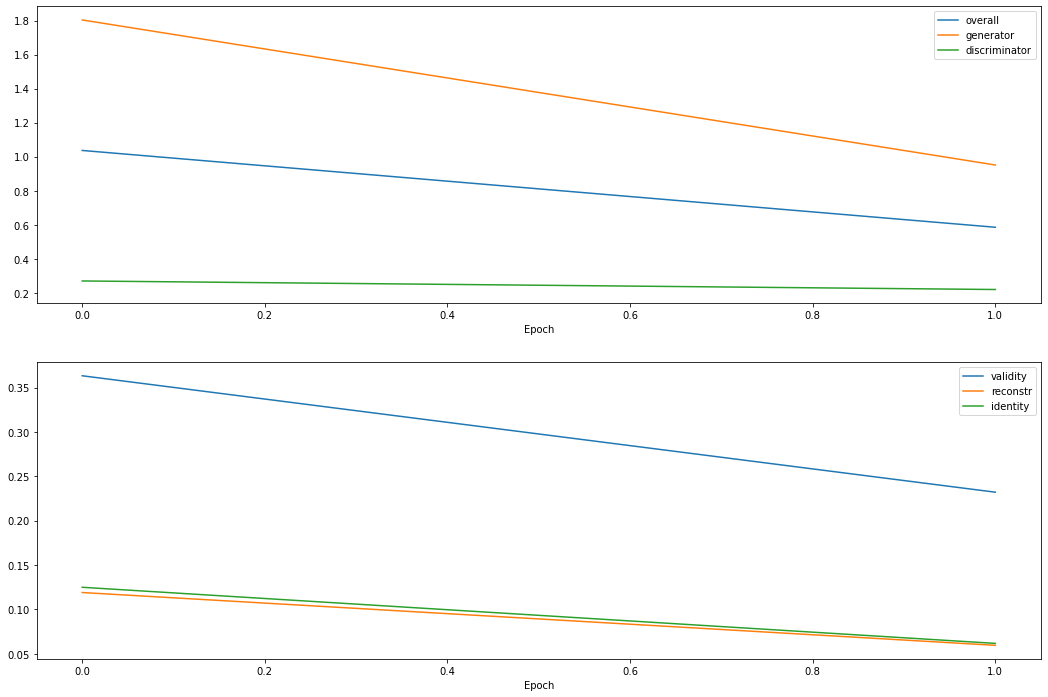

In [21]:
# Loss Plot
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(18, 12), facecolor='w')
epoch_num = len(model.losses)

axes[0].plot(np.arange(epoch_num), model.losses, label='overall')
axes[0].plot(np.arange(epoch_num), model.G_mean_losses, label='generator')
axes[0].plot(np.arange(epoch_num), model.D_mean_losses, label='discriminator')
axes[0].legend()
axes[0].set_xlabel('Epoch')

axes[1].plot(np.arange(epoch_num), model.validity, label='validity')
axes[1].plot(np.arange(epoch_num), model.reconstr, label='reconstr')
axes[1].plot(np.arange(epoch_num), model.identity, label='identity')
axes[1].legend()
axes[1].set_xlabel('Epoch')

plt.show()

In [22]:
torch.save(model.state_dict(), "/kaggle/working/model_ver1.pth")